In [37]:
!pip install folium

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import networkx as nx
import random

In [29]:
passagers = pd.read_csv("../data_chall_alstom/passagers.csv")
print(passagers.info())
plan_metro = pd.read_csv("../data_chall_alstom/plan_du_métro.csv")
print(plan_metro.info())
position_gps = pd.read_csv("../data_chall_alstom/position_gps_des_stations_de_métro.csv")
print(position_gps.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93942 entries, 0 to 93941
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   de      93942 non-null  object
 1   vers    93942 non-null  object
 2   nombre  93942 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   de Ligne      1010 non-null   object
 1   de Station    1010 non-null   object
 2   vers Ligne    1010 non-null   object
 3   vers Station  1010 non-null   object
dtypes: object(4)
memory usage: 31.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Station  386 non-null    object
 1   GPS      386 non-null    object
d

### Mis en forme des jeu de données

In [30]:
plan_metro_ligne = plan_metro[plan_metro["de Station"]!=plan_metro["vers Station"]]
position_gps['lat'], position_gps['lng'] = zip(*position_gps['GPS'].apply(lambda x: x.split(',')))
plan_metro_ligne=plan_metro_ligne[:-1]

In [31]:
stations=[]
"""
ligne_nb = list(range(1,15))
ligne_nb=[chr(x) for x in ligne_nb]
ligne_nb.append("3bis")
ligne_nb.append("7bis")
"""
ligne_nb=["1","2","3","3bis","4","5","6","7","8","9","10","11","12","13","14","7bis"]

for ligne in ligne_nb :
    liste_coord=[]
    df=plan_metro_ligne[plan_metro_ligne["de Ligne"]==ligne]
    station = df["de Station"].unique()

    for st in station:
        if not(position_gps[position_gps['Station']==st].empty):
            liste_coord.append([float(position_gps[position_gps['Station']==st].iat[0,3]), float(position_gps[position_gps['Station']==st].iat[0,2])])
        
    
    stations.append({'coordinates' : liste_coord, 'type': 'LineString'})

plan_ligne = pd.DataFrame()
plan_ligne["ligne"] = ligne_nb
plan_ligne["station"] = stations

### Representation graphique du reseau

In [32]:

idf_map = folium.Map(location=[48.868, 2.365], zoom_start=12, tiles='Cartodb dark_matter')


for segment in plan_ligne["station"]:
    gjson = folium.features.GeoJson(segment,
                                    style_function = lambda x: {'color': '#00C4B3',
                                                                'weight': 1.5})
    idf_map.add_child(gjson)


for i, v in position_gps.iterrows():
    folium.CircleMarker(location=[v['lat'], v['lng']],
                        radius=1.2,
                        color='#00C4B3',
                        fill_color='#00C4B3',
                        fill=True).add_to(idf_map)
idf_map

### Creation de la matrice

In [33]:
import math

#On calcule la distance avec la formule de Haversine
def calcul_distance(station1, station2):
    coord_station1 = position_gps.loc[position_gps["Station"] == station1, "GPS"].iloc[0]
    coord_station2 = position_gps.loc[position_gps["Station"] == station2, "GPS"].iloc[0]
    lat1 , lon1 = map(float, coord_station1.split(", "))
    lat2 , lon2 = map(float, coord_station2.split(", "))
    # Rayon de la Terre en kilomètres
    R = 6371.0
    
    # Convertir les degrés en radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Différences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Formule de Haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    
    # Distance
    distance = R * c
    return distance

def calcul_temps(station1,station2,vitesse):
    return round(calcul_distance(station1,station2)/vitesse*3600)

In [34]:
def creation_matrice(plan_metro, position):
    plan_metro_grouped = plan_metro.groupby("de Station")
    passagers_dict = passagers.set_index(["de", "vers"])["nombre"].to_dict()

    # Liste unique des stations
    liste_station = position["Station"].unique()

    # Initialisation d'un dictionnaire pour construire le graph
    graph_dict = {station: [] for station in liste_station}

    # Construction optimisée du graph
    for depuis in liste_station:
        lien = plan_metro_grouped.get_group(depuis)["vers Station"].unique() if depuis in plan_metro_grouped.groups else []

        # Créer une liste pour chaque station de départ
        for vers in liste_station:
            noeud = {
                "ligne": [],
                "temps": -1,
                "passager": passagers_dict.get((depuis, vers), -1) if depuis != vers else -1
            }

            if vers in lien:
                noeud["ligne"] = list(plan_metro[
                    (plan_metro["de Station"] == depuis) & 
                    (plan_metro["vers Station"] == vers)
                ]["de Ligne"])
                noeud["temps"] = calcul_temps(depuis, vers, 25)

            graph_dict[depuis].append(noeud)

    # Conversion en DataFrame
    graph = pd.DataFrame(graph_dict, index=liste_station)
    return graph

In [35]:
df=creation_matrice(plan_metro, position_gps)

In [36]:
print(df["Garibaldi"])

Boucicaut           {'ligne': [], 'temps': -1, 'passager': 4}
Bourse              {'ligne': [], 'temps': -1, 'passager': 5}
Bir-Hakeim          {'ligne': [], 'temps': -1, 'passager': 5}
Argentine           {'ligne': [], 'temps': -1, 'passager': 9}
Daumesnil           {'ligne': [], 'temps': -1, 'passager': 6}
                                      ...                    
Église de Pantin    {'ligne': [], 'temps': -1, 'passager': 6}
Château d'Eau       {'ligne': [], 'temps': -1, 'passager': 1}
Guy Môquet          {'ligne': [], 'temps': -1, 'passager': 2}
Monceau             {'ligne': [], 'temps': -1, 'passager': 5}
Rome                {'ligne': [], 'temps': -1, 'passager': 3}
Name: Garibaldi, Length: 261, dtype: object


In [37]:
def creation_graphe(matrice):
    # Création du graphe avec NetworkX à partir du DataFrame
    G = nx.DiGraph()

    # Ajouter des arêtes au graphe en utilisant les informations du DataFrame
    for start_station in matrice.index:
        for end_station in matrice.columns:
            connection = matrice.loc[start_station, end_station]
            if connection['ligne']!=[]:
                G.add_edge(start_station, end_station,
                        lines=connection['ligne'],
                        distance=connection['temps'])
    return G

In [38]:
G_metro = creation_graphe(df)

In [39]:
G_metro.number_of_edges()

583

In [40]:
nx.is_strongly_connected(G_metro)

False

In [41]:
def afficher_graph(G_metro):
    # Dessiner le graphe
    pos = nx.spring_layout(G_metro)  # Positionnement automatique des nœuds

    plt.figure(figsize=(12, 8))
    nx.draw(G_metro, pos, with_labels=True, node_color="lightblue", node_size=500, edge_color="gray", font_size=10, font_weight="bold")

    # Ajouter les labels des arêtes avec les informations (distance et passagers)
    edge_labels = {(u, v): f"{d['distance']} km"
                for u, v, d in G_metro.edges(data=True)}
    nx.draw_networkx_edge_labels(G_metro, pos, edge_labels=edge_labels, font_size=9)

    plt.title("Réseau de Métro avec Liaisons et Passagers")
    plt.show()

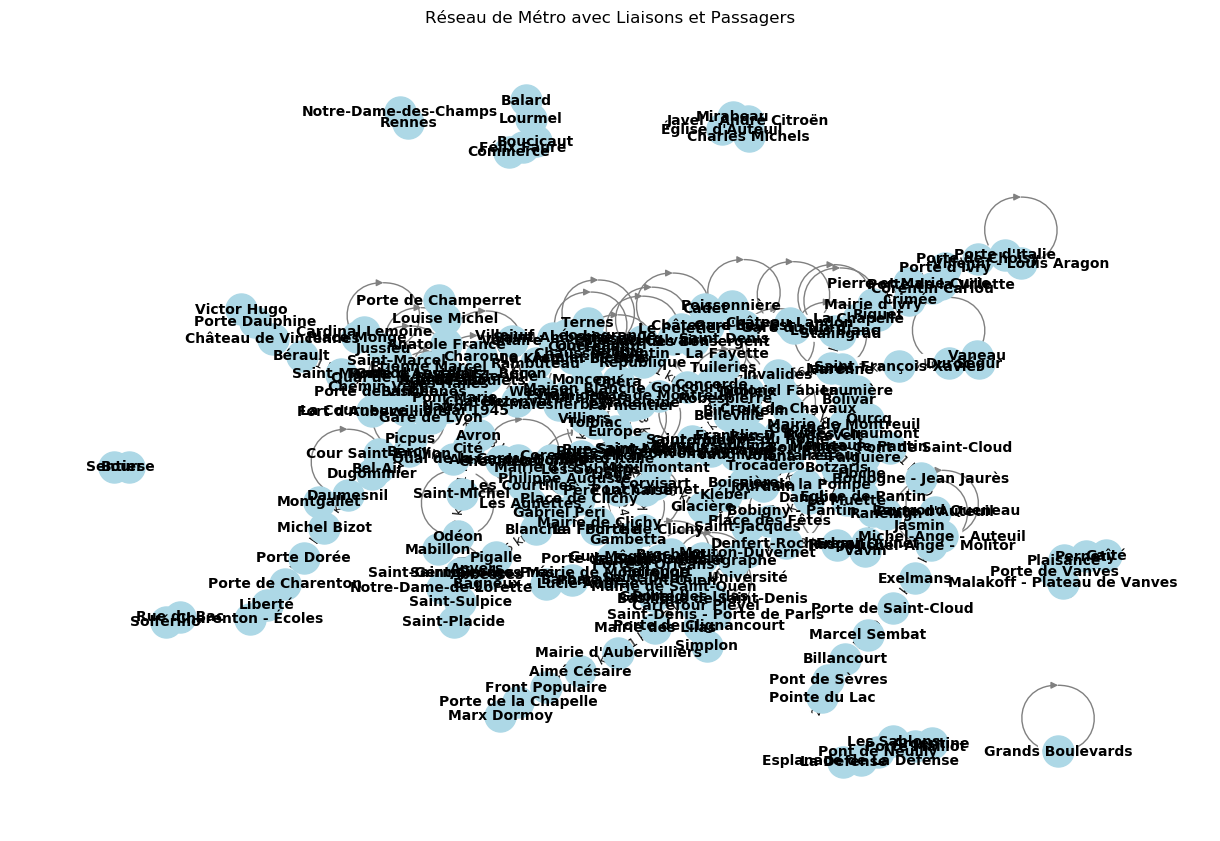

In [42]:
afficher_graph(G_metro)

In [43]:
def nombre_chemin(station1,station2, G):
    # Trouver tous les chemins entre Station_A et Station_F
    all_paths = list(nx.all_simple_paths(G, source=station1, target=station2))
    # Afficher les chemins avec des nformations détaillées
    return (len(all_paths))

In [44]:
nombre_chemin('Concorde','Invalides',G_metro)

1

In [45]:
plan_metro

,de Ligne,de Station,vers Ligne,vers Station
0,1,Charles de Gaulle - Étoile,2,Charles de Gaulle - Étoile
1,1,Charles de Gaulle - Étoile,6,Charles de Gaulle - Étoile
2,1,Franklin D. Roosevelt,9,Franklin D. Roosevelt
3,1,Champs-Élysées - Clemenceau,13,Champs-Élysées - Clemenceau
4,1,Concorde,8,Concorde
...,...,...,...,...
1005,14,Châtelet,14,Gare de Lyon
1006,14,Gare de Lyon,14,Bercy
1007,14,Bercy,14,Cour Saint-Émilion
1008,14,Cour Saint-Émilion,14,Bibliothèque François-Mitterrand


In [46]:
df_ligne_insuppressible = pd.DataFrame(columns=['de Ligne','de Station', 'vers Ligne', 'vers Station'])
df_ligne_suppressible = pd.DataFrame(columns=['de Ligne','de Station', 'vers Ligne', 'vers Station'])

In [47]:
compteur = 0
for index, row in plan_metro.iterrows():    
    stationDe = row['de Station']
    stationVers = row['vers Station']
    if stationDe != stationVers and stationDe in G_metro and stationVers in G_metro: 
        # Appelez la fonction pour obtenir le nombre de chemins
        nb_chemin = nombre_chemin(stationDe, stationVers, G_metro)
        print(f"Nombre de chemins entre {stationDe} et {stationVers}: {nb_chemin}")
        if nb_chemin > 1:
            compteur += 1
            df_ligne_suppressible.loc[len(df_ligne_suppressible)]=row
        else :
            df_ligne_insuppressible.loc[len(df_ligne_insuppressible)]=row
    else :
        df_ligne_insuppressible.loc[len(df_ligne_insuppressible)]=row
print('Nb_arete suppressible:',compteur)

Nombre de chemins entre Esplanade de La Défense et La Défense: 1
Nombre de chemins entre Pont de Neuilly et Esplanade de La Défense: 1
Nombre de chemins entre Les Sablons et Pont de Neuilly: 1
Nombre de chemins entre Porte Maillot et Les Sablons: 1
Nombre de chemins entre Argentine et Porte Maillot: 1
Nombre de chemins entre Franklin D. Roosevelt et George V: 1
Nombre de chemins entre Tuileries et Concorde: 1
Nombre de chemins entre Hôtel de Ville et Châtelet: 849
Nombre de chemins entre Saint-Paul et Hôtel de Ville: 1181
Nombre de chemins entre Bastille et Saint-Paul: 1181
Nombre de chemins entre Gare de Lyon et Bastille: 975
Nombre de chemins entre Porte de Vincennes et Nation: 1
Nombre de chemins entre Saint-Mandé et Porte de Vincennes: 1
Nombre de chemins entre Bérault et Saint-Mandé: 1
Nombre de chemins entre Château de Vincennes et Bérault: 1
Nombre de chemins entre Porte Dauphine et Château de Vincennes: 1
Nombre de chemins entre Victor Hugo et Porte Dauphine: 1
Nombre de chemin

In [48]:
print(len(df_ligne_insuppressible))
print(len(df_ligne_suppressible))

756
254


In [49]:
def generate_one_problem():
    # Étape 1 : Nombre aléatoire de lignes cassées à simuler
    nb_lignes_cassees = random.randint(1, 50)
    ##nb_lignes_cassees = random.randint(1, df_ligne_suppressible)

    lignes_cassees = df_ligne_suppressible.sample(nb_lignes_cassees)

    # Étape 3 : Créer le DataFrame final
    lignes_restantes = pd.concat([df_ligne_suppressible, lignes_cassees]).drop_duplicates(keep=False)

    # Combiner avec les lignes insuppressibles
    df_final = pd.concat([df_ligne_insuppressible, lignes_restantes], ignore_index=True)

    """# Affichage des résultats
    print("Lignes insuppressibles :")
    print(df_ligne_insuppressible)
    print("\nLignes suppressibles (complètes) :")
    print(df_ligne_suppressible)
    print(f"\nLignes cassées (aléatoires, {nb_lignes_cassees} lignes) :")
    print(lignes_cassees)
    print("\nDataFrame final combiné :")
    print(df_final)"""
    return df_final

In [50]:
def generate_train_dataset(n):
    train_dataset = []
    for _ in range (n):
        train_dataset.append(generate_one_problem())
    return train_dataset

In [51]:
dataset_train1 = generate_train_dataset(200)

In [52]:
dataset_train1[70]

,de Ligne,de Station,vers Ligne,vers Station
0,1,Charles de Gaulle - Étoile,2,Charles de Gaulle - Étoile
1,1,Charles de Gaulle - Étoile,6,Charles de Gaulle - Étoile
2,1,Franklin D. Roosevelt,9,Franklin D. Roosevelt
3,1,Champs-Élysées - Clemenceau,13,Champs-Élysées - Clemenceau
4,1,Concorde,8,Concorde
...,...,...,...,...
957,14,Saint-Lazare,14,Madeleine
958,14,Madeleine,14,Pyramides
959,14,Pyramides,14,Châtelet
960,14,Châtelet,14,Gare de Lyon


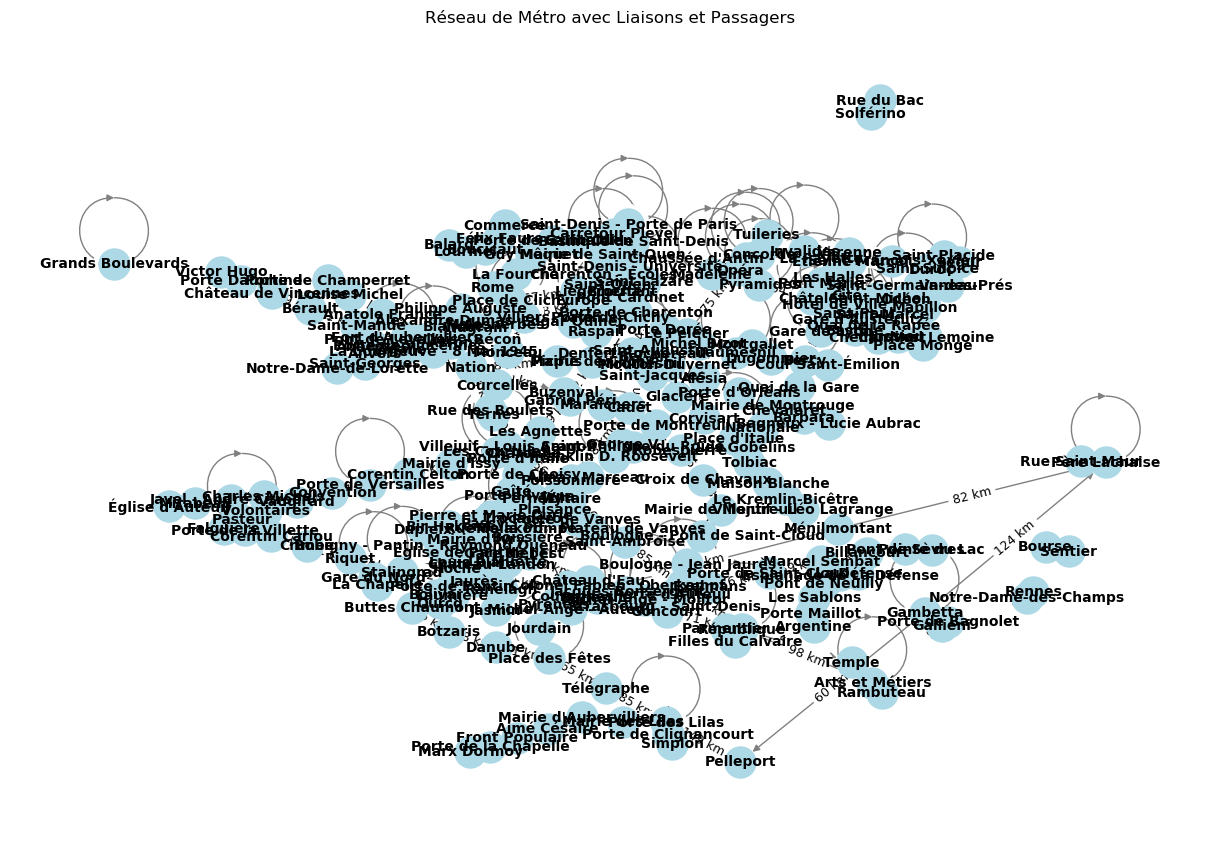

In [53]:
afficher_graph(creation_graphe(creation_matrice(dataset_train1[70],position_gps)))